# Autoencoders

## Summary

- Introduction
- Stacked autoencoders
- Variational autoencoders

## Introduction

### Autoencoders in a nutshell

Autoencoders are a type of network that aims to **encode** an input in a *latent space* and then **decode** it back.

[![Autoencoder principle](images/keras_autoencoders_applications.png)](https://towardsdatascience.com/deep-autoencoders-using-tensorflow-c68f075fd1a3)

### Autoencoder architecture

An autoencoder is composed of an encoding function $E(x)$ outputting a latent representation $s$, a decoding function $D(s)$ computing the reconstructed output $o$ and a loss function $\mathcal{L}$ measuring the distance between original and reconstructed data.

[![Autoencoder architecture](images/keras_autoencoder_arch_flow.png)](https://www.pyimagesearch.com/2020/02/17/autoencoders-with-keras-tensorflow-and-deep-learning/)

### What's the point?

An autoencoder learns to copy its inputs to its outputs under some constraints: for example, limiting the dimensionality of the latent space, or adding noise to the inputs.

To do its job, it must find efficient ways of representing the data: for example, learning the most relevant features and dropping the others.

### Latent space properties

The latent space learned by an autoencoder may have interesting properties.

For example, in a latent space of images of faces, there may be a *smile vector* $s$, such that if latent point $z$ is the representation of a certain face, then latent point $z + s$ is the representation of the same face, smiling. It becomes possible to add a smile to existing images.

[![Smile vector](images/smile_vector.jpg)](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwjppNaU9b3sAhWXA2MBHVvmCksQFjABegQIBhAC&url=https%3A%2F%2Farxiv.org%2Fpdf%2F1609.04468&usg=AOvVaw2tyR7sXaBPhviw4wg0Jgrf)

### Autoencoders applications

- Dimensionality reduction
- Denoising
- Data generation
- Anomaly detection
  - Network is trained on normal samples only.
  - Outliers will induce a high reconstruction loss and will be flagged as anomalies.

### Example: performing dimensionality reduction with a linear autoencoder

(Heavily inspired by Chapter 17 of [Hands-On Machine Learning](https://github.com/ageron/handson-ml2) by Aurélien Géron)

#### Environment setup

In [1]:
import platform

print(f"Python version: {platform.python_version()}")
assert platform.python_version_tuple() >= ("3", "6")

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

Python version: 3.7.5


In [2]:
# Setup plots
%matplotlib inline
plt.rcParams["figure.figsize"] = 10, 8
%config InlineBackend.figure_format = 'retina'
sns.set()

In [3]:
import tensorflow as tf

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Layer, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.metrics import binary_accuracy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

TensorFlow version: 2.3.1
Keras version: 2.4.0


In [4]:
def plot_loss(history):
    """Plot training loss
    Takes a Keras History object as parameter"""

    loss = history.history["loss"]
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(10, 10))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, loss, ".--", label="Training loss")
    final_loss = loss[-1]
    title = "Training loss: {:.4f}".format(final_loss)
    plt.ylabel("Loss")
    if "val_loss" in history.history:
        val_loss = history.history["val_loss"]
        plt.plot(epochs, val_loss, "o-", label="Validation loss")
        final_val_loss = val_loss[-1]
        title += ", Validation loss: {:.4f}".format(final_val_loss)
    plt.title(title)
    plt.legend()

#### 3D data generation

In [5]:
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

x_train_3d = generate_3d_data(60)
x_train_3d = x_train_3d - x_train_3d.mean(axis=0, keepdims=0)
print(f"x_train: {x_train_3d.shape}")

x_train: (60, 3)


In [6]:
# Plot 3D data
fig = px.scatter_3d(x_train_3d, x=0, y=1, z=2, labels={"0": "x1", "1": "x2", "2": "x3"})
fig.show()

#### Model definition

In [7]:
dimred_encoder = Sequential([Dense(2, input_shape=(3,))])
dimred_decoder = Sequential([Dense(3, input_shape=(2,))])

dimred_ae = Sequential([dimred_encoder, dimred_decoder])
dimred_ae.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 2)                 8         
_________________________________________________________________
sequential_1 (Sequential)    (None, 3)                 9         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


#### Model training

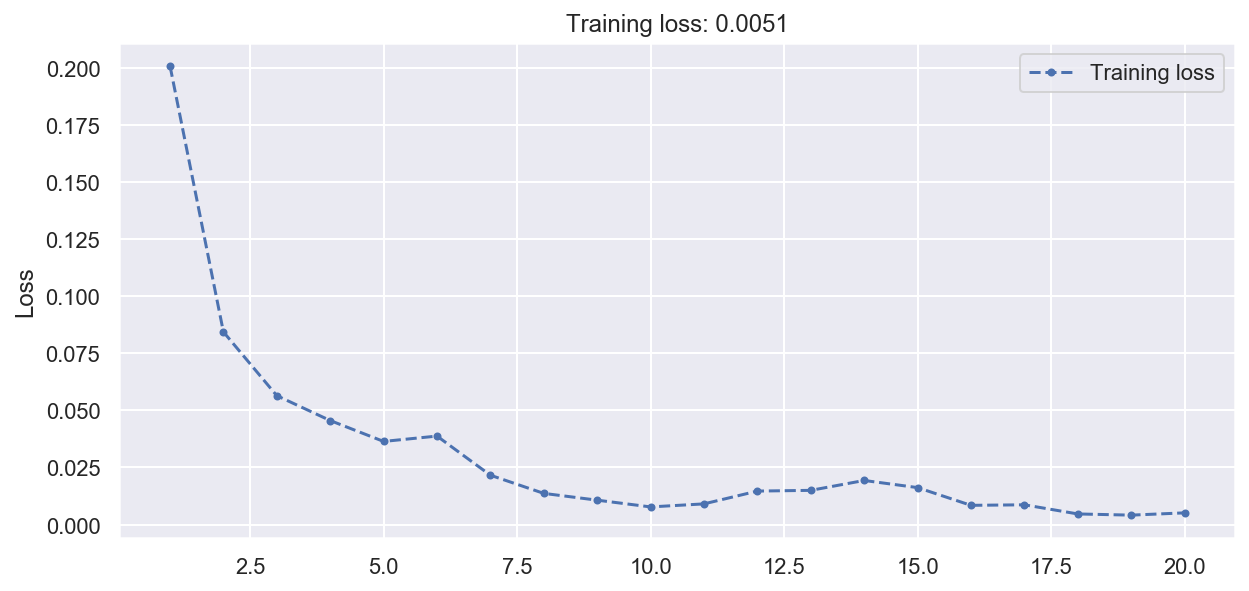

In [8]:
dimred_ae.compile(loss="mse", optimizer=SGD(lr=1.5))

# Same dataset is used for inputs and targets
history = dimred_ae.fit(x_train_3d, x_train_3d, epochs=20, verbose=0)

plot_loss(history)

#### Encoded data representation

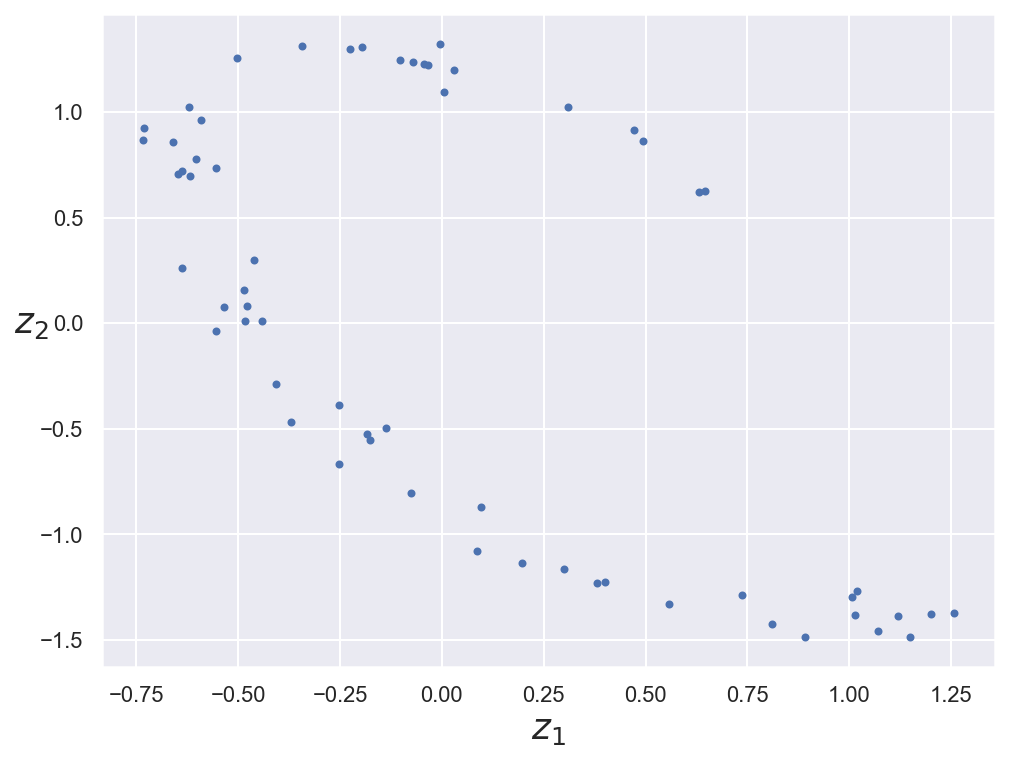

In [9]:
# Plot encoded representation (2D projection) of training data
codings = dimred_encoder.predict(x_train_3d)

fig = plt.figure(figsize=(8, 6))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.show()

## Stacked autoencoders

### Architecture

Stacked autoencoders have multiple hidden layers and are typically *symmetrical*. Adding more layers helps them learn more complex codings.

[![Stacked AE architecture](images/stacked_ae_ageron.png)](https://github.com/ageron/handson-ml2)

### Example: reconstructing fashion images with a stacked autoencoder

(Heavily inspired by Chapter 17 of [Hands-On Machine Learning](https://github.com/ageron/handson-ml2) by Aurélien Géron)

#### Data loading and preprocessing

In [10]:
# Load the Keras MNIST digits dataset
(train_images, _), (test_images, _) = fashion_mnist.load_data()

x_train_fashion = train_images / 255.0
x_test_fashion = test_images / 255.0

x_train_fashion, x_val_fashion = x_train_fashion[:-5000], x_train_fashion[-5000:]
print(
    f"x_train: {x_train_fashion.shape}. x_val: {x_val_fashion.shape}. x_test: {x_test_fashion.shape}"
)

x_train: (55000, 28, 28). x_val: (5000, 28, 28). x_test: (10000, 28, 28)


#### The SELU activation function

- *Self-normalizing Exponential Linear Unit*.
- Introduced in a [2017 paper](https://arxiv.org/abs/1706.02515) by Klambauer et al.
- Can solve the vanishing/exploding gradients problems for deep feedforward networks.

#### Model definition

In [11]:
# For each input image, the encoder outputs a vector of size 30
stacked_encoder = Sequential(
    [
        Flatten(input_shape=(28, 28)),
        Dense(100, activation="selu"),
        Dense(30, activation="selu"),
    ]
)
stacked_decoder = Sequential(
    [
        Dense(100, activation="selu", input_shape=(30,)),
        Dense(28 * 28, activation="sigmoid"),
        Reshape((28, 28)),
    ]
)
stacked_ae = Sequential([stacked_encoder, stacked_decoder])

stacked_ae.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 30)                81530     
_________________________________________________________________
sequential_4 (Sequential)    (None, 28, 28)            82284     
Total params: 163,814
Trainable params: 163,814
Non-trainable params: 0
_________________________________________________________________


#### Model training

In [12]:
def rounded_accuracy(y_true, y_pred):
    """Define a custom accuracy metric by round predictions"""
    
    return binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [13]:
stacked_ae.compile(
    loss="binary_crossentropy", optimizer=SGD(lr=1.5), metrics=[rounded_accuracy]
)

history = stacked_ae.fit(
    x_train_fashion,
    x_train_fashion,
    epochs=20,
    validation_data=(x_val_fashion, x_val_fashion),
    verbose=0
)

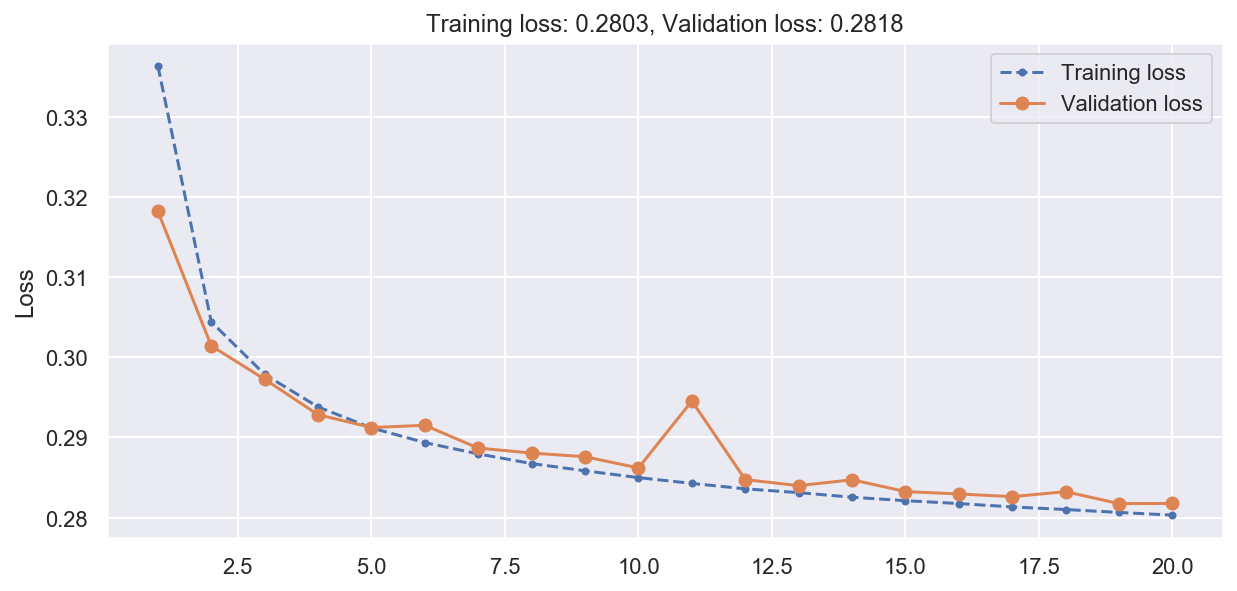

In [14]:
# Plot training history
plot_loss(history)

#### Reconstructions visualization

In [15]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def show_reconstructions(model, images=x_val_fashion, n_images=5):
    """Show original and reconstructed images side-by-side"""
    
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

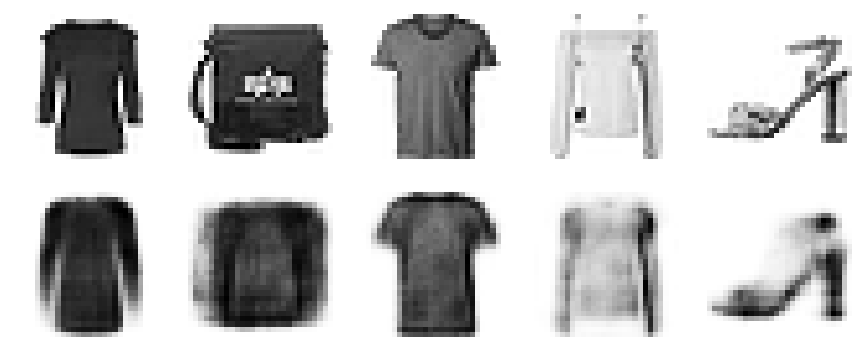

In [16]:
# Display some validation images with their reconstructions
show_reconstructions(stacked_ae)

## Variational autoencoders

### Principle

VAE were introduced simultaneously in late 2013 by two research teams ([Kingma et al](https://arxiv.org/abs/1312.6114), [Rezende et al](https://arxiv.org/abs/1401.4082)). 

Instead of encoding it into a fixed representation in the latent space, a VAE turns its input into the parameters of a *statistical distribution* modeling the data: a mean $\mu$ and a standard deviation $\sigma$. By sampling points from this distribution, one can generate new input data samples: a VAE is a *generative model*.

![VAE principle](images/vae_fchollet.jpg)

### VAE losses

The parameters of a VAE are trained via two loss functions: 

- a **reconstruction loss** forcing the decoded samples to match the initial inputs ;
- a **latent loss** that forces the autoencoder to have codings that look as though they were sampled from a simple Gaussian distribution.

Technically, the latent loss is inplemented as the **Kullback-Leibler divergence** between the target and actual codings distributions.

$$\mathcal{L}_{latent} = -\frac{1}{2}\sum_{i=1}^K (1 + \gamma_i - e^{\gamma_i} - {\mu_i}^2)$$

- $K$: codings' dimensionality.
- $\mu_i$ and $\sigma_i$: mean and standard deviation of the $ith$ components of the codings.
- $\gamma_i = log_e({\sigma_i}^2)$ is a term introduced for numerical stability.

### Example: generating fashion images with a VAE

(Heavily inspired by Chapter 17 of [Hands-On Machine Learning](https://github.com/ageron/handson-ml2) by Aurélien Géron)

#### Model definition

In [17]:
class Sampling(Layer):
    """Custom Keras layer to sample the codings (the vector encoding a digit)"""
    
    def call(self, inputs):
        # Takes mean and log_var (gamma) as parameters
        mean, log_var = inputs
        # Sample a random codings vector with same shape as gamma from a Gaussian distribution 
        # exp(gamma/2) = sigma
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

In [18]:
latent_dim = 10

# Define encoder model
original_inputs = Input(shape=(28, 28), name="encoder_input")
z = Flatten(name="flattened_input")(original_inputs)
z = Dense(150, activation="selu")(z)
z = Dense(100, activation="selu")(z)
codings_mean = Dense(latent_dim, name="codings_mean")(z)
codings_log_var = Dense(latent_dim, name="codings_log_var")(z)
codings = Sampling()((codings_mean, codings_log_var))

vae_encoder = Model(inputs=original_inputs, outputs=codings, name="encoder")

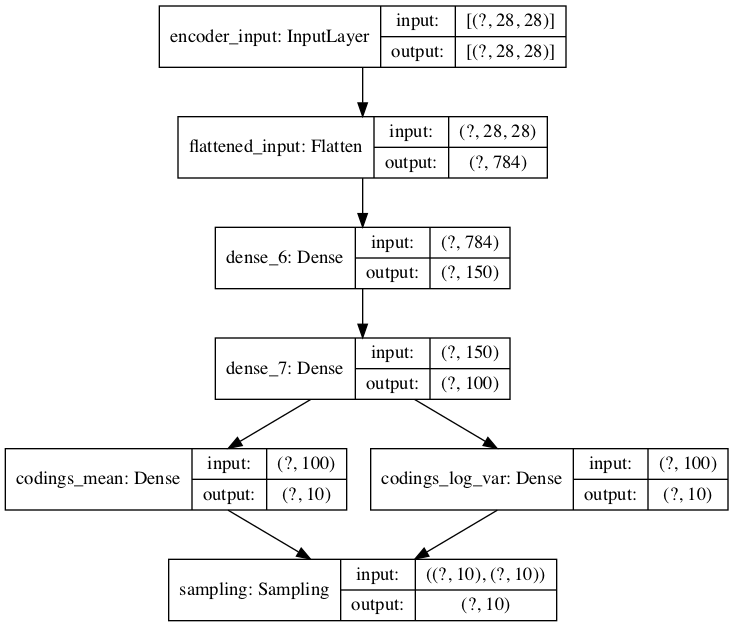

In [29]:
# Plot non-sequential encoder as graph
plot_model(vae_encoder, show_shapes=True)

In [20]:
# Define decoder model
latent_inputs = Input(shape=(latent_dim,))
x = Dense(100, activation="selu")(latent_inputs)
x = Dense(150, activation="selu")(x)
x = Dense(28 * 28, activation="sigmoid")(x)
outputs = Reshape((28, 28))(x)

vae_decoder = Model(inputs=latent_inputs, outputs=outputs, name="decoder")

vae_decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               1100      
_________________________________________________________________
dense_9 (Dense)              (None, 150)               15150     
_________________________________________________________________
dense_10 (Dense)             (None, 784)               118384    
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28)            0         
Total params: 134,634
Trainable params: 134,634
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Define VAE model
codings = vae_encoder(original_inputs)
outputs = vae_decoder(codings)
vae = Model(inputs=original_inputs, outputs=outputs, name="vae")

# Add KL divergence regularization loss
latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
vae.add_loss(K.mean(latent_loss) / 784.)

#### Model training

In [22]:
# Train the VAE
vae.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=[rounded_accuracy])

history = vae.fit(
    x_train_fashion,
    x_train_fashion,
    epochs=25,
    batch_size=128,
    validation_data=(x_val_fashion, x_val_fashion),
    verbose=0,
)

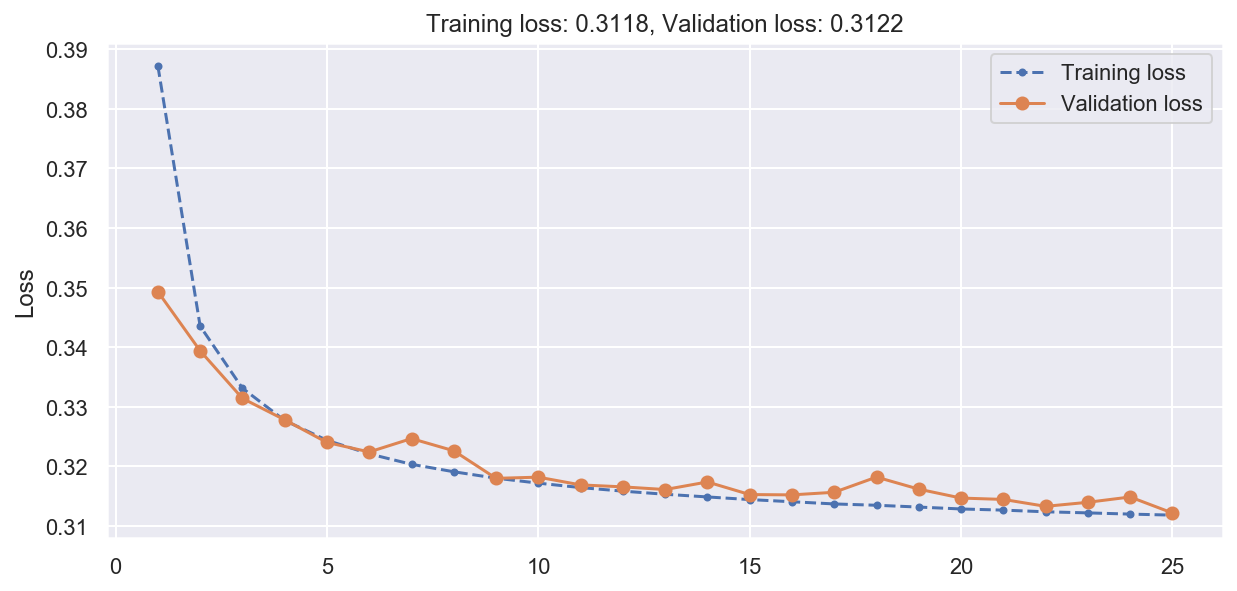

In [23]:
plot_loss(history)

#### Reconstructions visualization

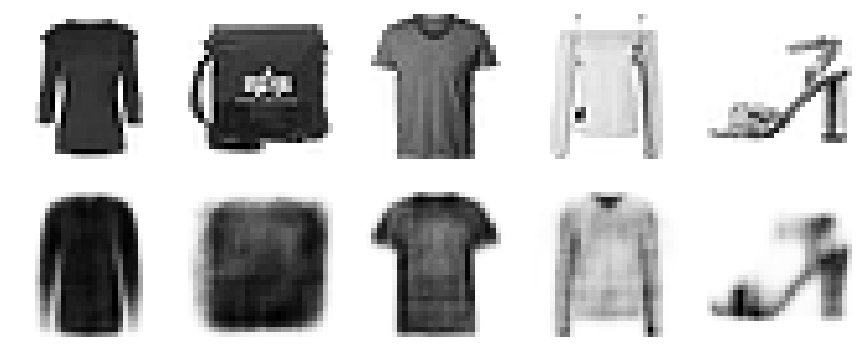

In [24]:
show_reconstructions(vae)
plt.show()

#### Generating new images

In [25]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols*2, n_rows*2))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

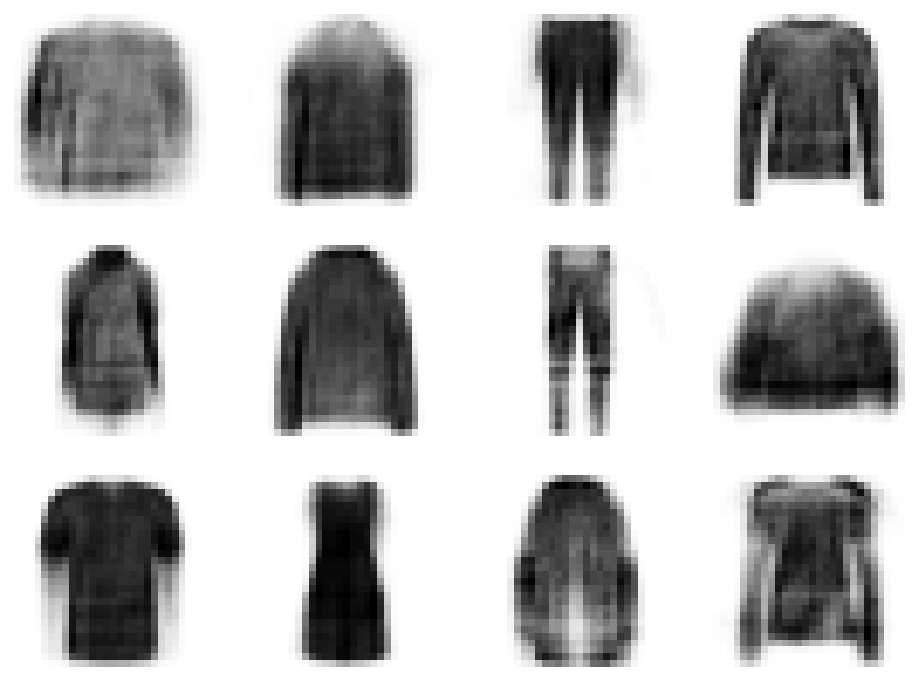

In [26]:
# Generate random codings
codings = tf.random.normal(shape=[12, latent_dim])
# Decode them as new images
images = vae_decoder(codings).numpy()
plot_multiple_images(images, 4)